In [1]:
from utils import Polarity

import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patches as mpatches

sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [2]:
df = pd.read_csv('../political_news.csv', parse_dates=['date'])
vecs = np.load('../training/bestmodel.model.dv.vectors.npy')

polarity_obj = Polarity(df, vecs, period_length='1d')
polarity_df = polarity_obj.get_polarity()

In [3]:
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # olive
    '#17becf',  # light blue
    '#ff9896',  # light orange
    '#98df8a',  # light green
    '#ffbb78',  # light red
    '#c5b0d5',  # light purple
    '#c49c94'   # light brown
]
comb_colors_dict = {v:k for v,k in zip(polarity_obj.combs, colors)}

In [4]:
polarity_df['D_ewma'] = polarity_df.groupby('comb', group_keys=False)['D'].apply(lambda x: x.ewm(alpha=0.05).mean())
polarity_df['B_ewma'] = polarity_df.groupby('comb', group_keys=False)['B'].apply(lambda x: x.ewm(alpha=0.05).mean())
polarity_df['cluster'] = polarity_df['comb'].isin(polarity_obj.between_combs).map({True:'Between', False:'Within'})

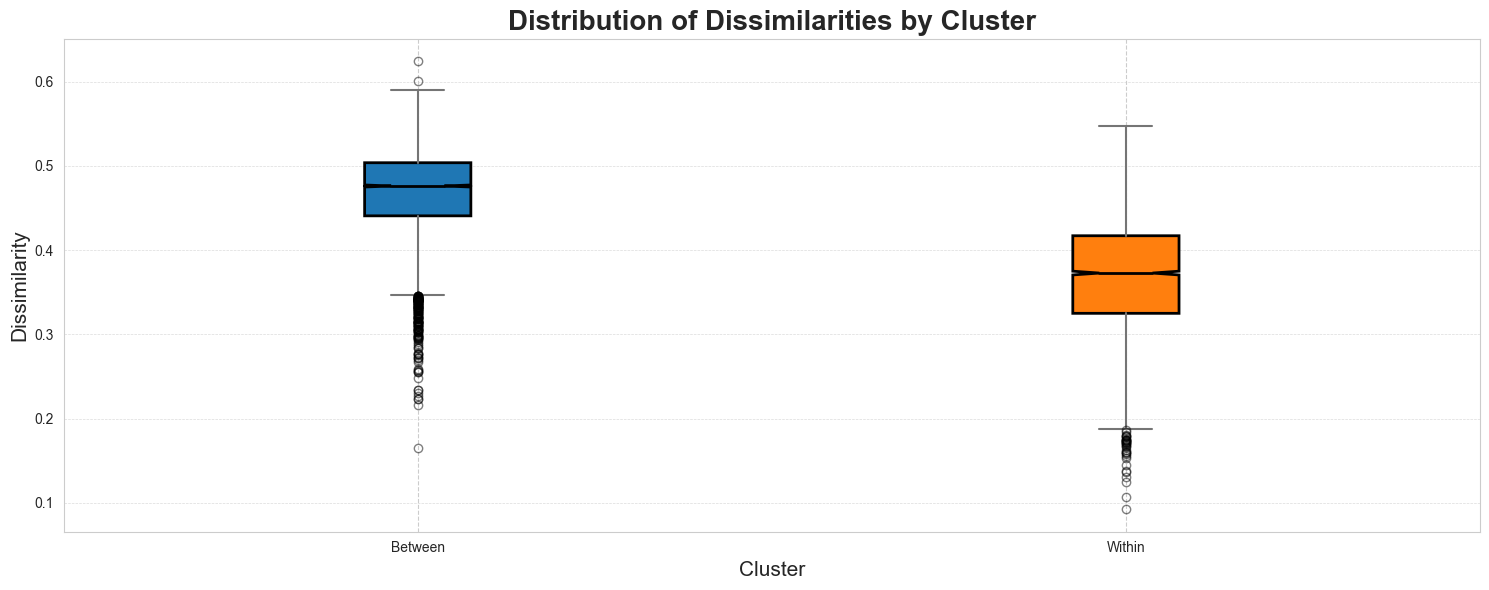

In [5]:
grouped_data = polarity_df.groupby('cluster')['D'].apply(list)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Plotting the boxplot
boxplot = ax.boxplot(grouped_data.values, notch=True, sym='o', vert=True, patch_artist=True)

# Customize the boxplot colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Customize the outlier markers
for flier in boxplot['fliers']:
    flier.set(marker='o', color='#e377c2', alpha=0.5)

# Customize the whiskers and caps
for whisker, cap in zip(boxplot['whiskers'], boxplot['caps']):
    whisker.set(color='#757575', linewidth=1.5)
    cap.set(color='#757575', linewidth=1.5)

# Customize the medians and boxes
for median, box in zip(boxplot['medians'], boxplot['boxes']):
    median.set(color='#000000', linewidth=2)
    box.set(linewidth=2)

# Adding labels and title
ax.set_xlabel('Cluster', fontsize=15)
ax.set_ylabel('Dissimilarity', fontsize=15)
ax.set_title('Distribution of Dissimilarities by Cluster', fontsize=20, fontweight='bold')

# Customizing x-axis labels
ax.set_xticklabels(grouped_data.index, fontsize=10)

ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust layout
plt.tight_layout()

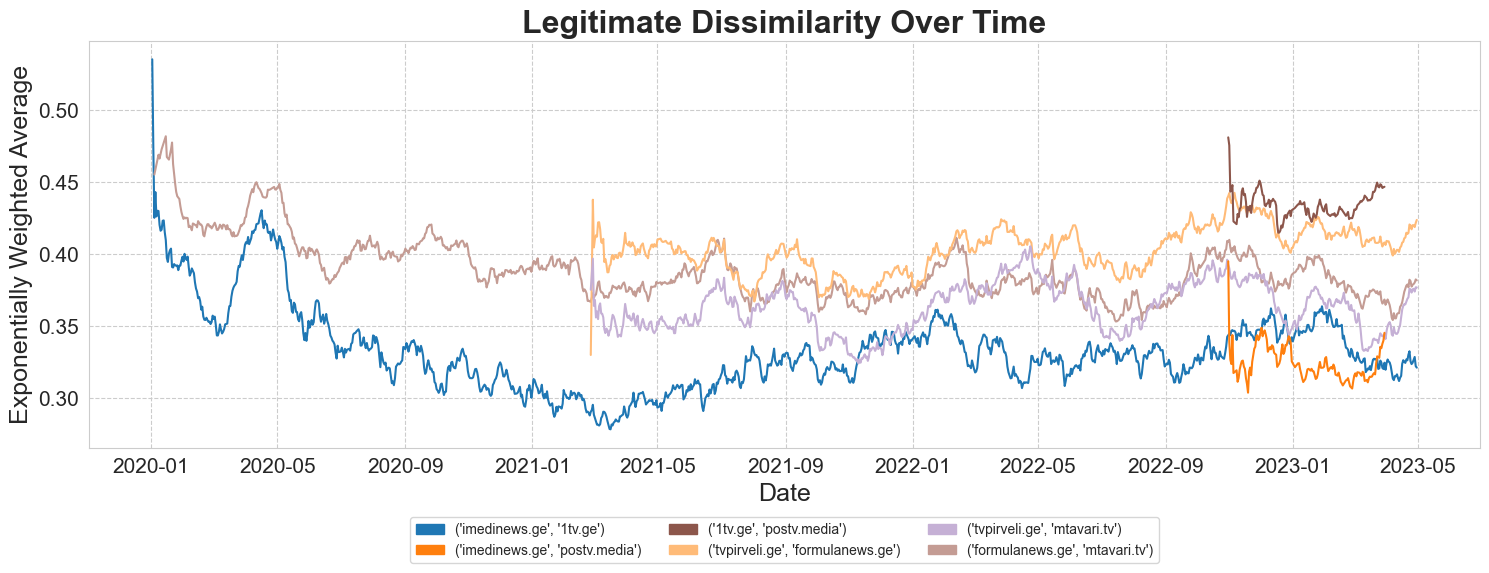

In [6]:
# Create a figure and axis object
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 6])

# Plot the line graph
sns.lineplot(
    data=polarity_df[polarity_df['cluster'] == 'Within'],
    x='date',
    y='D_ewma',
    hue='comb',
    palette=comb_colors_dict,
    ax=ax
)

# Create legend handles
legend_labels = polarity_obj.within_combs
legend_colors = [comb_colors_dict[label] for label in legend_labels]
patch_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]

# Add legend to the plot
ax.legend(handles=patch_handles, loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)

# Set plot title, axis labels, and tick parameters
ax.set_title('Legitimate Dissimilarity Over Time', fontsize=23, fontweight='bold')
ax.set_ylabel('Exponentially Weighted Average', fontsize=18)
ax.set_xlabel('Date', fontsize=18)
ax.tick_params(axis='both', labelsize=15)

# Adjust layout
plt.tight_layout()

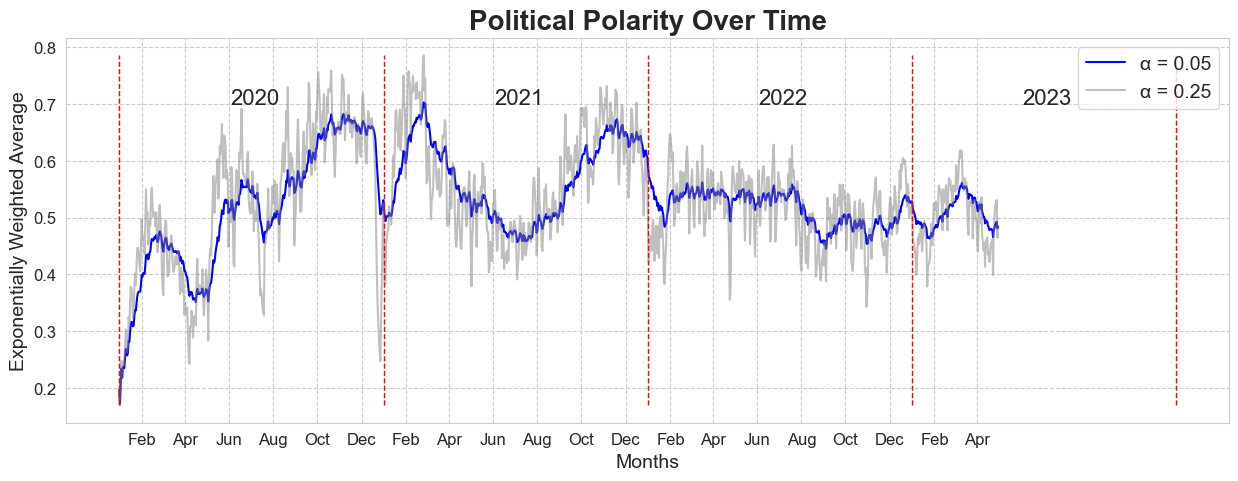

In [7]:
def normalize_column(col):
    """
    Normalize the values of a column between 0 and 1.
    """
    return (col - col.min()) / (col.max() - col.min())

# Group by date and calculate the sum of polarity
agg_polarity = polarity_df.groupby('date').agg({'polarity': 'sum'})

# Normalize the polarity values
agg_polarity['polarity'] = normalize_column(agg_polarity['polarity'])

# Calculate exponentially weighted moving averages
agg_polarity['polarity_ewma0.05'] = agg_polarity['polarity'].ewm(alpha=0.05).mean()
agg_polarity['polarity_ewma0.25'] = agg_polarity['polarity'].ewm(alpha=0.25).mean()

# Create a figure and axes for the plot
fig, ax = plt.subplots(figsize=[15, 5])

# Plot the line for α = 0.05
sns.lineplot(data=agg_polarity, x='date', y='polarity_ewma0.05', ax=ax, label='α = 0.05', alpha=1, c='blue')

# Plot the line for α = 0.25
sns.lineplot(data=agg_polarity, x='date', y='polarity_ewma0.25', ax=ax, label='α = 0.25', alpha=0.5, c='grey')

# Add a legend
ax.legend(fontsize=14, loc='upper right')

# Add vertical lines for each year
for year in [2020, 2021, 2022, 2023, 2024]:
    ax.plot([datetime(year, 1, 1), datetime(year, 1, 1)],
            [agg_polarity['polarity_ewma0.25'].min(), agg_polarity['polarity_ewma0.25'].max()],
            c='r', lw=1, linestyle='--', alpha=1)
    ax.annotate(year, xy=(datetime(year, 6, 2), 0.7), fontsize=16)

# Set the x-axis tick labels
x_ticks = [date for date in agg_polarity.index if date.day == 1 and date.month % 2 == 0]
ax.set_xticks(x_ticks)
ax.set_xticklabels([date.strftime('%b') for date in x_ticks])

# Add gridlines
ax.grid(True, linestyle='--')

# Set tick label font size
ax.tick_params(axis='both', labelsize=12)

# Set x and y-axis labels, and title
ax.set_xlabel('Months', fontsize=14)
ax.set_ylabel('Exponentially Weighted Average', fontsize=14)
ax.set_title('Political Polarity Over Time', fontsize=20, fontweight='bold');

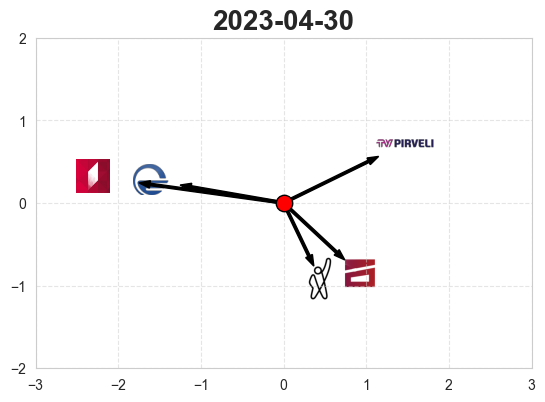

In [8]:
polarity_obj.save_animation()